## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda:0


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
       BatchNorm1d-3                  [-1, 300]             600
              ReLU-4                  [-1, 300]               0
            Linear-5                  [-1, 200]          60,200
       BatchNorm1d-6                  [-1, 200]             400
              ReLU-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
       BatchNorm1d-9                  [-1, 100]             200
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 20]           2,020
      BatchNorm1d-12                   [-1, 20]              40
             ReLU-13                   [-1, 20]               0
           Linear-14                   

In [9]:
def train_step(model, data_loader, loss_function, optimizer, device=device):
    model.train()
    loss_list = []
    classes_pred = []
    classes_true = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_hat = model(x_batch)
        loss = loss_function(y_hat, y_batch)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        classes_true.extend(y_batch.cpu())
        classes_pred.extend(torch.argmax(y_hat, axis=1).cpu())

    mean_loss = round(np.mean(loss_list), 4)
    correct_total = (np.array(classes_true) == np.array(classes_pred)).sum()
    acc = round(correct_total / len(classes_true), 4)
    print(f'Train loss: {mean_loss}, accuracy: {acc}')
    return mean_loss, acc

In [10]:
def test_step(model, data_loader, loss_function, device=device):
    model.eval()
    loss_list = []
    classes_pred = []
    classes_true = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat = model(x_batch)

            loss = loss_function(y_hat, y_batch)
            loss_list.append(loss.item())
            
            classes_true.extend(y_batch.cpu())
            classes_pred.extend(torch.argmax(y_hat, axis=1).cpu())
    correct_total = (np.array(classes_true) == np.array(classes_pred)).sum()
    acc = round(correct_total / len(classes_pred), 4)
    mean_loss = round(np.mean(loss_list), 4)
    print(f'Test loss: {mean_loss}, accuracy: {acc}')
    return mean_loss, acc

Your experiments come here:

In [11]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30
loss_list = []
for epoch_i in range(num_epochs):
    print(f'Epoch: {epoch_i + 1}')
    train_step(model, train_loader, loss_func, opt)
    test_step(model, test_loader, loss_func)

# Your experiments, training and validation loops here

Epoch: 1
Train loss: 0.6487, accuracy: 0.8278
Test loss: 0.4337, accuracy: 0.851
Epoch: 2
Train loss: 0.3547, accuracy: 0.8758
Test loss: 0.3686, accuracy: 0.8645
Epoch: 3
Train loss: 0.3105, accuracy: 0.8888
Test loss: 0.3777, accuracy: 0.858
Epoch: 4
Train loss: 0.2804, accuracy: 0.8985
Test loss: 0.3516, accuracy: 0.8705
Epoch: 5
Train loss: 0.2618, accuracy: 0.904
Test loss: 0.3247, accuracy: 0.8779
Epoch: 6
Train loss: 0.2403, accuracy: 0.9118
Test loss: 0.3211, accuracy: 0.8815
Epoch: 7
Train loss: 0.2263, accuracy: 0.9153
Test loss: 0.3168, accuracy: 0.8856
Epoch: 8
Train loss: 0.2125, accuracy: 0.921
Test loss: 0.3101, accuracy: 0.8899
Epoch: 9
Train loss: 0.1977, accuracy: 0.9267
Test loss: 0.2999, accuracy: 0.8912
Epoch: 10
Train loss: 0.1851, accuracy: 0.9317
Test loss: 0.3213, accuracy: 0.8843
Epoch: 11
Train loss: 0.1752, accuracy: 0.9349
Test loss: 0.368, accuracy: 0.8756
Epoch: 12
Train loss: 0.1671, accuracy: 0.9378
Test loss: 0.3581, accuracy: 0.8777
Epoch: 13
Train lo

Test loss: 0.448, accuracy: 0.8899

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [13]:
len(fmnist_dataset_train)

60000

In [14]:
ratio = 0.2
indices = list(range(0, int(len(fmnist_dataset_train) * ratio)))
fmnist_dataset_train_small = torch.utils.data.Subset(fmnist_dataset_train, indices)

In [15]:
train_loader_small = torch.utils.data.DataLoader(fmnist_dataset_train_small, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 200]          60,200
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 20]           2,020
              ReLU-9                   [-1, 20]               0
           Linear-10                   [-1, 10]             210
Total params: 318,030
Trainable params: 318,030
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.21
Estimated T

In [17]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 100
train_scores_overfit = []
test_scores_overfit = []
for epoch_i in range(num_epochs):
    print(f'Epoch: {epoch_i + 1}')
    train_scores_overfit.append(train_step(model, train_loader_small, loss_func, opt))
    test_scores_overfit.append(test_step(model, test_loader, loss_func))


Epoch: 1
Train loss: 1.4555, accuracy: 0.4429
Test loss: 0.8861, accuracy: 0.6278
Epoch: 2
Train loss: 0.7291, accuracy: 0.7381
Test loss: 0.6521, accuracy: 0.7556
Epoch: 3
Train loss: 0.5659, accuracy: 0.7881
Test loss: 0.5705, accuracy: 0.7867
Epoch: 4
Train loss: 0.4972, accuracy: 0.8128
Test loss: 0.5164, accuracy: 0.8131
Epoch: 5
Train loss: 0.4522, accuracy: 0.8333
Test loss: 0.4998, accuracy: 0.8117
Epoch: 6
Train loss: 0.4125, accuracy: 0.8503
Test loss: 0.472, accuracy: 0.8352
Epoch: 7
Train loss: 0.373, accuracy: 0.8653
Test loss: 0.4595, accuracy: 0.8415
Epoch: 8
Train loss: 0.3611, accuracy: 0.869
Test loss: 0.4569, accuracy: 0.8444
Epoch: 9
Train loss: 0.3408, accuracy: 0.8747
Test loss: 0.4309, accuracy: 0.8546
Epoch: 10
Train loss: 0.3188, accuracy: 0.8838
Test loss: 0.4675, accuracy: 0.8333
Epoch: 11
Train loss: 0.2984, accuracy: 0.8918
Test loss: 0.4322, accuracy: 0.8535
Epoch: 12
Train loss: 0.2965, accuracy: 0.8908
Test loss: 0.4774, accuracy: 0.8407
Epoch: 13
Train 

Test loss: 1.0309, accuracy: 0.8605


In [18]:
import matplotlib.pyplot as plt

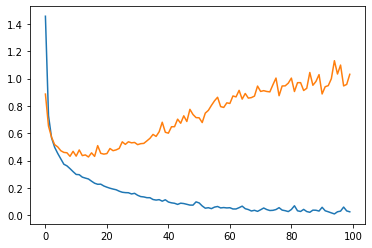

In [19]:
train_scores_overfit = np.array(train_scores_overfit)
test_scores_overfit = np.array(test_scores_overfit)
plt.plot(range(len(train_scores_overfit)), train_scores_overfit[:, 0])
plt.plot(range(len(test_scores_overfit)), test_scores_overfit[:, 0])

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.25),
            nn.Linear(input_shape, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(20, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 300]         235,500
       BatchNorm1d-4                  [-1, 300]             600
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 200]          60,200
           Dropout-7                  [-1, 200]               0
       BatchNorm1d-8                  [-1, 200]             400
              ReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 100]          20,100
      BatchNorm1d-11                  [-1, 100]             200
             ReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 20]           2,020
          Dropout-14                   

In [22]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 100
train_scores_fixed = []
test_scores_fixed = []
for epoch_i in range(num_epochs):
    print(f'Epoch: {epoch_i + 1}')
    train_scores_fixed.append(train_step(model, train_loader_small, loss_func, opt))
    test_scores_fixed.append(test_step(model, test_loader, loss_func))

Epoch: 1
Train loss: 1.3079, accuracy: 0.5873
Test loss: 0.6232, accuracy: 0.7858
Epoch: 2
Train loss: 0.7115, accuracy: 0.7558
Test loss: 0.549, accuracy: 0.8027
Epoch: 3
Train loss: 0.6058, accuracy: 0.7929
Test loss: 0.4891, accuracy: 0.8231
Epoch: 4
Train loss: 0.5661, accuracy: 0.8085
Test loss: 0.48, accuracy: 0.8327
Epoch: 5
Train loss: 0.5341, accuracy: 0.816
Test loss: 0.4696, accuracy: 0.8355
Epoch: 6
Train loss: 0.5152, accuracy: 0.824
Test loss: 0.4897, accuracy: 0.8301
Epoch: 7
Train loss: 0.4772, accuracy: 0.8347
Test loss: 0.4438, accuracy: 0.846
Epoch: 8
Train loss: 0.4689, accuracy: 0.8409
Test loss: 0.4326, accuracy: 0.8508
Epoch: 9
Train loss: 0.4455, accuracy: 0.8472
Test loss: 0.441, accuracy: 0.8537
Epoch: 10
Train loss: 0.4335, accuracy: 0.8527
Test loss: 0.4463, accuracy: 0.8455
Epoch: 11
Train loss: 0.4285, accuracy: 0.8538
Test loss: 0.4572, accuracy: 0.8412
Epoch: 12
Train loss: 0.4217, accuracy: 0.8538
Test loss: 0.4141, accuracy: 0.8561
Epoch: 13
Train loss

Test loss: 0.5188, accuracy: 0.8701


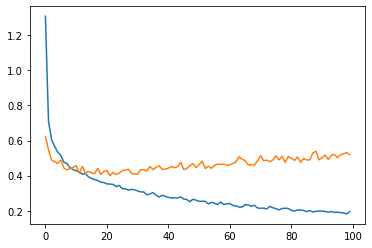

In [23]:
train_scores_fixed = np.array(train_scores_fixed)
test_scores_fixed = np.array(test_scores_fixed)
plt.plot(range(len(train_scores_fixed)), train_scores_fixed[:, 0])
plt.plot(range(len(test_scores_fixed)), test_scores_fixed[:, 0])

### Conclusions:

_Write down small report with your conclusions and your ideas._

В моделях не использовал конволюционные слои (поэтому качество могло пострадать)
Пункт 2 и 3 обучал на урезанной выборке (20% от исходной)

1. Сеть с линейными слоями и регуляризацией (без conv слоев) может достичь приемлимого уровня аккуратноcти (>= 0.885) на тестовой выборке.

2. Добавление слоев (усложнение модели) влечет к переобучению - сложная модель "запоминает" примеры из обучающего набора и под них подстраивается. На графике можем заметить, как после **20-25** итерации ошибка на валидации начинает расти
<img src="screens/plot_model_without_reg.png">

3. Использование техники регуляризации (dropout, batchnorm). Эксперементировал с "интенсивностью" регуляризации. Если переборщить (после каждого линейного слоя ставить batchnorm и dropout), модель учится очень медленно (медленно с точки зрения изменения величины ошибки). При ослаблении ограничений (после каждого слоя или batchnorm или dropout), получилось найти баланс между моделями из п.2 и сильнозарегулированной. По графику видно, что значение ошибки на валидационной выборке более устойчивое (нет резкого подьема, как в случае с моделью без регуляризации)

<img src="screens/plot_model_with_reg.png">